# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project_imageGen/project-image_generation

/content/drive/MyDrive/Project_imageGen/project-image_generation


In [3]:
!pwd

/content/drive/MyDrive/Project_imageGen/project-image_generation


In [4]:
pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 5.8 MB/s eta 0:00:00


In [5]:
#Importing
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import torch

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import uuid
import shutil

import ignite
from ignite.metrics import FID

from modules import UNet
from modules import UNet_2xUD
from modules import UNet_2xUD_halfchannels


seed = 449
random.seed(seed)
torch.manual_seed(seed)
num_images = 500
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [6]:
torch.cuda.is_available()

False

# Trying out the GAN

In [7]:
nc = 3      # number of channels in training image
nz = 128    # latent vector size

# size of feature maps in generator and discriminator
ngf = 64
ndf = 64

num_epochs = 1024
lr = 0.0002
beta1 = 0.5
ngpu = 1
smoothed = True
noised = True

In [8]:
def imshow(img, title=""):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [9]:
def save_images(images, path, **kwargs):
    # grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = images.permute(1, 2, 0).to('cpu').numpy()
    print(ndarr.shape)
    im = Image.fromarray(ndarr)
    im.save(path)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.relu = nn.ReLU(True)
        self.cvt1 = nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        
        self.cvt2 = nn.ConvTranspose2d(ngf * 4, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)

        self.cvt3 = nn.ConvTranspose2d(ngf * 4, ngf, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)

        self.cvt4 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.cvt1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.cvt2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.cvt3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.cvt4(x)
        x = self.tanh(x)
        return x

# Doing GAN 1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt

In [ ]:

path = "models/CatGAN/1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(500, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path))

loaded.eval()
out = loaded(noise).cpu()
out= out.detach()


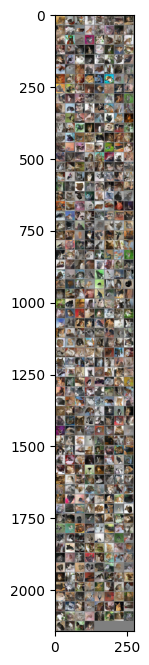

In [ ]:

img_folder = "1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G_images/"
#print(out)
#print(out.shape)
output_folder = os.path.join("output/", img_folder)
#shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)


# Save each image individually
for i, image in enumerate(out):
  image_path = os.path.join(output_folder, f"{i}.png")
  toPIL = transforms.ToPILImage()
  #ndarr = ((image /2 +0.5)*255).permute(1,2,0).numpy()
  #print(ndarr)
  newPIL = toPIL(image/2 + 0.5)
  #newPIL.show()
  newPIL.save(image_path)
  #im = Image.fromarray(ndarr)
  #plt.imshow((image/2 + 0.5).permute(1,2,0))
  #im.save(image_path)

# Display the image grid

img_grid = torchvision.utils.make_grid(out)
imshow(img_grid)


In [ ]:
print(len([name for name in os.listdir(os.path.join("./output/", img_folder))]))

500


In [11]:
pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!python -m pytorch_fid output/1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G_images output/test_images

100% 10/10 [03:18<00:00, 19.81s/it]
100% 10/10 [03:14<00:00, 19.41s/it]
FID:  156.47835650459126


# Doing GAN 1024ep_64nf_128nz_default-D_default-G.pt

In [12]:
# Other generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 4 x 4``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 8 x 8``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 16 x 16``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 32 x 32``
        )

    def forward(self, x):
        return self.net(x)

In [18]:

path = "models/CatGAN/1024ep_64nf_128nz_default-D_default-G.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(500, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path, map_location=device))

loaded.eval()
out = loaded(noise).cpu()
out= out.detach()


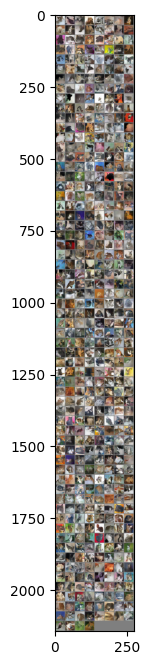

In [19]:

img_folder = "1024ep_64nf_128nz_default-D_default-G_images/"
#print(out)
#print(out.shape)
output_folder = os.path.join("output/", img_folder)
#shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)


# Save each image individually
for i, image in enumerate(out):
  image_path = os.path.join(output_folder, f"{i}.png")
  toPIL = transforms.ToPILImage()
  #ndarr = ((image /2 +0.5)*255).permute(1,2,0).numpy()
  #print(ndarr)
  newPIL = toPIL(image/2 + 0.5)
  #newPIL.show()
  newPIL.save(image_path)
  #im = Image.fromarray(ndarr)
  #plt.imshow((image/2 + 0.5).permute(1,2,0))
  #im.save(image_path)

# Display the image grid

img_grid = torchvision.utils.make_grid(out)
imshow(img_grid)


In [20]:
print(len([name for name in os.listdir(os.path.join("./output/", img_folder))]))

500


In [21]:
!python -m pytorch_fid output/1024ep_64nf_128nz_default-D_default-G_images output/test_images

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 198MB/s]
100% 10/10 [03:24<00:00, 20.48s/it]
100% 10/10 [03:25<00:00, 20.52s/it]
FID:  140.2756513163407


# Doing GAN 512ep_64nf_128nz_default-D_default-G.pt

In [23]:

path = "models/CatGAN/512ep_64nf_128nz_default-D_default-G.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(500, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path, map_location=device))

loaded.eval()
out = loaded(noise).cpu()
out= out.detach()


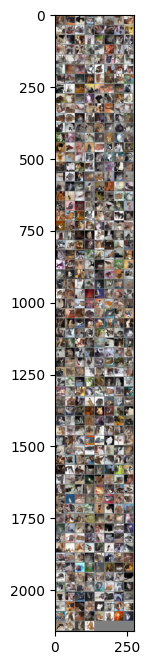

In [24]:

img_folder = "512ep_64nf_128nz_default-D_default-G_images/"
#print(out)
#print(out.shape)
output_folder = os.path.join("output/", img_folder)
#shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)


# Save each image individually
for i, image in enumerate(out):
  image_path = os.path.join(output_folder, f"{i}.png")
  toPIL = transforms.ToPILImage()
  #ndarr = ((image /2 +0.5)*255).permute(1,2,0).numpy()
  #print(ndarr)
  newPIL = toPIL(image/2 + 0.5)
  #newPIL.show()
  newPIL.save(image_path)
  #im = Image.fromarray(ndarr)
  #plt.imshow((image/2 + 0.5).permute(1,2,0))
  #im.save(image_path)

# Display the image grid

img_grid = torchvision.utils.make_grid(out)
imshow(img_grid)


In [25]:
print(len([name for name in os.listdir(os.path.join("./output/", img_folder))]))

500


In [26]:
!python -m pytorch_fid output/512ep_64nf_128nz_default-D_default-G_images output/test_images

100% 10/10 [03:16<00:00, 19.63s/it]
100% 10/10 [03:12<00:00, 19.21s/it]
FID:  142.16749272957304
